
--- Base SVR Model ---
MSE: 9.9042, RMSE: 3.1471, MAE: 2.4922, R²: 0.8441, MAPE: 89.17%

Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV completed.

Best Hyperparameters found: {'C': np.float64(27.55546207779663), 'epsilon': np.float64(0.03279351625419417), 'gamma': np.float64(0.0019112758217777906), 'kernel': 'rbf'}

--- Tuned SVR Model ---
MSE: 5.1258, RMSE: 2.2640, MAE: 1.7710, R²: 0.9193, MAPE: 68.57%


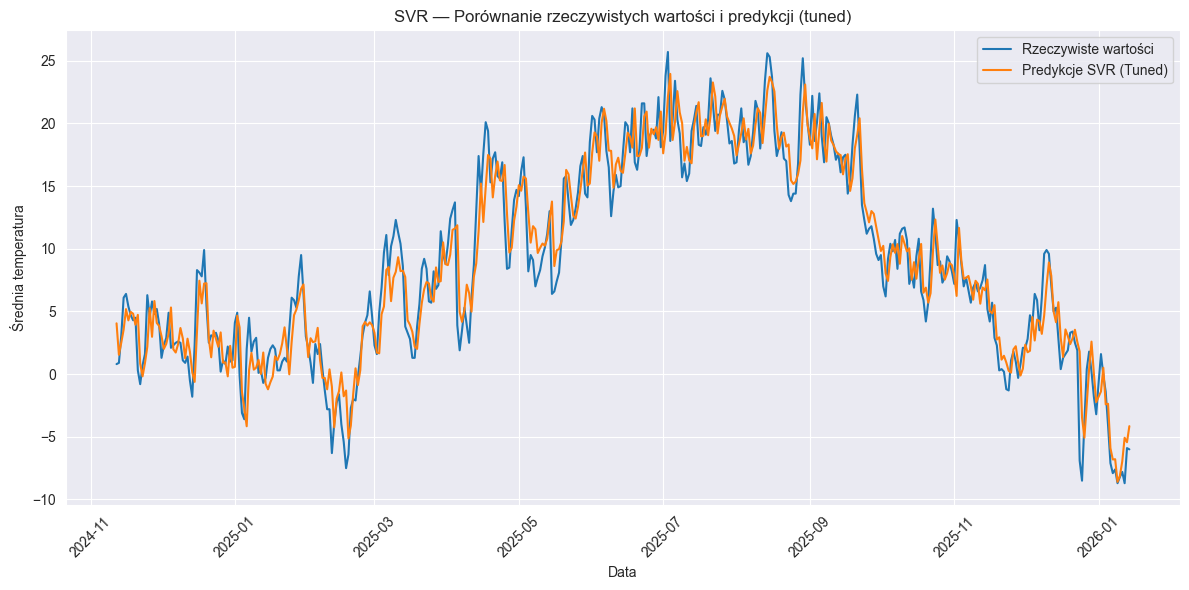

In [14]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import loguniform, uniform
import matplotlib.pyplot as plt

# =========================
# Ścieżka do pliku
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean2.csv", parse_dates=["time"])

# =========================
# Filtrujemy dane dla Warszawy i dodajemy cechy czasowe
# =========================
df_city = df[df['city'] == 'Warszawa'].copy()
df_city['month'] = df_city['time'].dt.month
df_city['weekday'] = df_city['time'].dt.weekday
df_city = df_city[['time', 'temp', 'month', 'weekday']]
df_city.sort_values("time", inplace=True)

# =========================
# Tworzenie sekwencji czasowych
# =========================
def create_sequences(df, window=60):
    sequences = []
    labels = []
    for i in range(len(df) - window):
        seq_tavg = df['temp'].iloc[i:i+window].values
        seq_month = df['month'].iloc[i:i+window].values
        seq_weekday = df['weekday'].iloc[i:i+window].values
        seq = np.column_stack((seq_tavg, seq_month, seq_weekday))
        sequences.append(seq.flatten())
        labels.append(df['temp'].iloc[i + window])
    return np.array(sequences), np.array(labels)

window = 60
sequences, labels = create_sequences(df_city, window=window)

# =========================
# Skalowanie danych
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(sequences)
y_scaled = scaler_y.fit_transform(labels.reshape(-1,1))

# =========================
# Podział na zbiór treningowy i testowy
# =========================
train_size = int(len(X_scaled) * 0.8)
X_train_scaled = X_scaled[:train_size]
X_test_scaled  = X_scaled[train_size:]
y_train_scaled = y_scaled[:train_size]
y_test_scaled  = y_scaled[train_size:]

# =========================
# Podstawowy SVR
# =========================
base_svr = SVR(kernel='rbf', C=10000, gamma='scale')
base_svr.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_scaled = base_svr.predict(X_test_scaled)
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).ravel()

mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / (y_test_original + np.finfo(float).eps))) * 100

print("\n--- Base SVR Model ---")
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

# =========================
# RandomizedSearchCV - tuning SVR
# =========================
param_dist = {
    'C': loguniform(1e1, 1e5),
    'gamma': loguniform(1e-4, 1e-1),
    'epsilon': uniform(0.01, 0.1),
    'kernel': ['rbf']
}

random_search = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions=param_dist,
    n_iter=50,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

print("\nStarting RandomizedSearchCV...")
random_search.fit(X_train_scaled, y_train_scaled.ravel())
print("RandomizedSearchCV completed.")

best_params = random_search.best_params_
print("\nBest Hyperparameters found:", best_params)

# =========================
# Trening SVR z najlepszymi hiperparametrami
# =========================
best_svr = SVR(**best_params)
best_svr.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_scaled_tuned = best_svr.predict(X_test_scaled)
y_pred_original_tuned = scaler_y.inverse_transform(y_pred_scaled_tuned.reshape(-1,1)).ravel()

mse_tuned = mean_squared_error(y_test_original, y_pred_original_tuned)
rmse_tuned = np.sqrt(mse_tuned)
mae_tuned = mean_absolute_error(y_test_original, y_pred_original_tuned)
r2_tuned = r2_score(y_test_original, y_pred_original_tuned)
mape_tuned = np.mean(np.abs((y_test_original - y_pred_original_tuned) / (y_test_original + np.finfo(float).eps))) * 100

print("\n--- Tuned SVR Model ---")
print(f"MSE: {mse_tuned:.4f}, RMSE: {rmse_tuned:.4f}, MAE: {mae_tuned:.4f}, R²: {r2_tuned:.4f}, MAPE: {mape_tuned:.2f}%")

# =========================
# Wykres rzeczywiste vs predykcje
# =========================
plt.figure(figsize=(12,6))
plt.plot(df_city['time'].iloc[-len(y_test_original):], y_test_original, label='Rzeczywiste wartości')
plt.plot(df_city['time'].iloc[-len(y_pred_original_tuned):], y_pred_original_tuned, label='Predykcje SVR (Tuned)')
plt.xlabel("Data")
plt.ylabel("Średnia temperatura")
plt.title("SVR — Porównanie rzeczywistych wartości i predykcji (tuned)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# Ścieżka do pliku
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean2.csv", parse_dates=["time"])

# =========================
# Filtrujemy dane dla Warszawy
# =========================
df_city = df[df['city'] == 'Warszawa'][['time','temp']].copy()
df_city.sort_values("time", inplace=True)

# =========================
# Tworzenie sekwencji czasowych
# =========================
def create_sequences(df, window=60):
    sequences = []
    labels = []
    for i in range(len(df) - window):
        seq = df['temp'].iloc[i:i+window].values
        label = df['temp'].iloc[i + window]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

window = 60
sequences, labels = create_sequences(df_city, window=window)

# =========================
# Skalowanie danych
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(sequences)
y_scaled = scaler_y.fit_transform(labels.reshape(-1,1))

# =========================
# Walk-Forward Cross-Validation dla SVR
# =========================
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
mae_scores = []
mse_scores = []
r2_scores = []

fold = 1

for train_index, test_index in tscv.split(X_scaled):
    print(f"\nFold {fold}")
    
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]
    
    # =========================
    # Trening SVR z najlepszymi parametrami
    # =========================
    svr = SVR(
        kernel='rbf',
        C=27.55546,
        gamma=0.001911275,
        epsilon=0.03279351

    )
    svr.fit(X_train, y_train.ravel())
    
    y_pred_scaled = svr.predict(X_test).reshape(-1,1)
    
    # Odwrócenie skalowania
    y_test_rescaled = scaler_y.inverse_transform(y_test)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)
    
    mse  = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2   = r2_score(y_test_rescaled, y_pred_rescaled)
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    print(f"R²: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")
    
    fold += 1

# =========================
# Podsumowanie cross-validation
# =========================
print("\nWalk-Forward Cross-Validation — SVR (tuned parameters)")
print(f"R²   : {np.mean(r2_scores):.4f}")
print(f"MAE  : {np.mean(mae_scores):.4f}")
print(f"MSE  : {np.mean(mse_scores):.4f}")
print(f"RMSE : {np.mean(rmse_scores):.4f}")



Fold 1
R²: 0.9087 | MAE: 1.9305 | MSE: 5.8398 | RMSE: 2.4166

Fold 2
R²: 0.9096 | MAE: 1.9008 | MSE: 5.7069 | RMSE: 2.3889

Fold 3
R²: 0.9148 | MAE: 1.9367 | MSE: 5.9596 | RMSE: 2.4412

Fold 4
R²: 0.9266 | MAE: 1.6930 | MSE: 4.6491 | RMSE: 2.1562

Fold 5
R²: 0.9232 | MAE: 1.7817 | MSE: 4.9933 | RMSE: 2.2346

Walk-Forward Cross-Validation — SVR (tuned parameters)
R²   : 0.9166
MAE  : 1.8485
MSE  : 5.4297
RMSE : 2.3275


01:22:56 - cmdstanpy - INFO - Chain [1] start processing
01:22:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Metryki Prophet (Cross-Validation):
R²   : 0.9919
MSE  : 0.5857
RMSE : 0.7536
MAE  : 0.5648


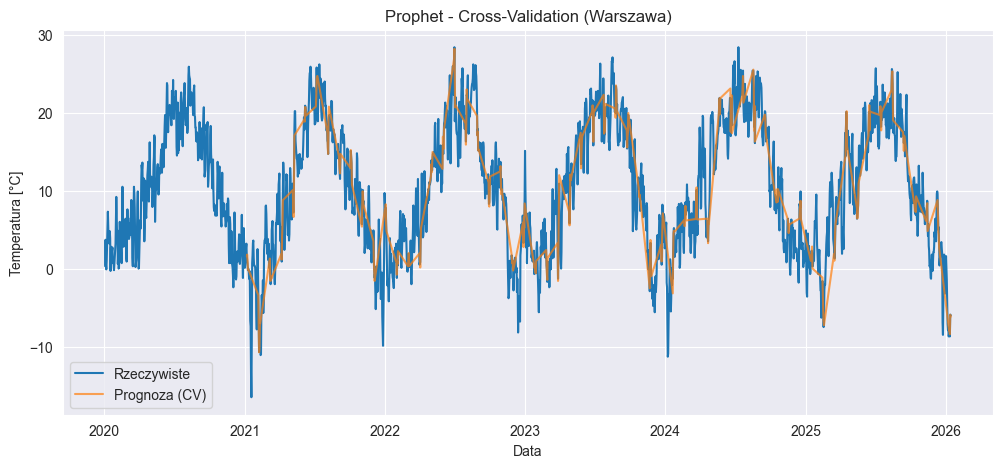

In [35]:
import os
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# =========================
# 1. Wczytanie danych
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean2.csv", parse_dates=["time"])

# =========================
# =========================
# 1. Filtracja miasta i przygotowanie danych
# =========================
cols_needed = ['time','temp','tmin','tmax','prcp','wspd','pres']
df_city = df[df['city']=='Warszawa'][cols_needed].copy()
df_city.sort_values("time", inplace=True)
df_city.rename(columns={'time':'ds','temp':'y'}, inplace=True)

# =========================
# 2. Definicja modelu Prophet z regresorami
# =========================
model = Prophet(
    yearly_seasonality=15,
    weekly_seasonality=10,
    daily_seasonality=False,
    changepoint_prior_scale=0.1
)

# Sezonowość miesięczna
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Dodanie regresorów
regressors = ['tmin','tmax','prcp','wspd','pres']
for reg in regressors:
    model.add_regressor(reg)
model.fit(df_city)
# =========================
# 3. Trenowanie modelu
# =========================


# =========================
# 4. Cross-Validation
# =========================
df_cv = cross_validation(
    model,
    initial='365 days',
    period='30 days',
    horizon='5 days',
    parallel="processes"
)

# =========================
# 5. Obliczenie metryk + R² ręcznie
# =========================
df_p = performance_metrics(df_cv)
y_true = df_cv['y'].values
y_pred = df_cv['yhat'].values
r2 = r2_score(y_true, y_pred)

print("Metryki Prophet (Cross-Validation):")
print(f"R²   : {r2:.4f}")
print(f"MSE  : {df_p['mse'].mean():.4f}")
print(f"RMSE : {df_p['rmse'].mean():.4f}")
print(f"MAE  : {df_p['mae'].mean():.4f}")

# =========================
# 6. Wykres rzeczywiste vs prognozy
# =========================
plt.figure(figsize=(12,5))
plt.plot(df_city['ds'], df_city['y'], label='Rzeczywiste')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Prognoza (CV)', alpha=0.7)
plt.title("Prophet - Cross-Validation (Warszawa)")
plt.xlabel("Data")
plt.ylabel("Temperatura [°C]")
plt.legend()
plt.grid(True)
plt.show()


Prognoza 5 dni do przodu (Warszawa):
             ds      yhat  yhat_lower  yhat_upper
2204 2026-01-15 -7.993747   -8.922412   -7.062121
2205 2026-01-16 -7.192155   -8.178323   -6.289687
2206 2026-01-17 -8.532641   -9.463471   -7.596689
2207 2026-01-18 -5.968702   -6.893212   -5.027584
2208 2026-01-19 -6.169974   -7.142210   -5.235044


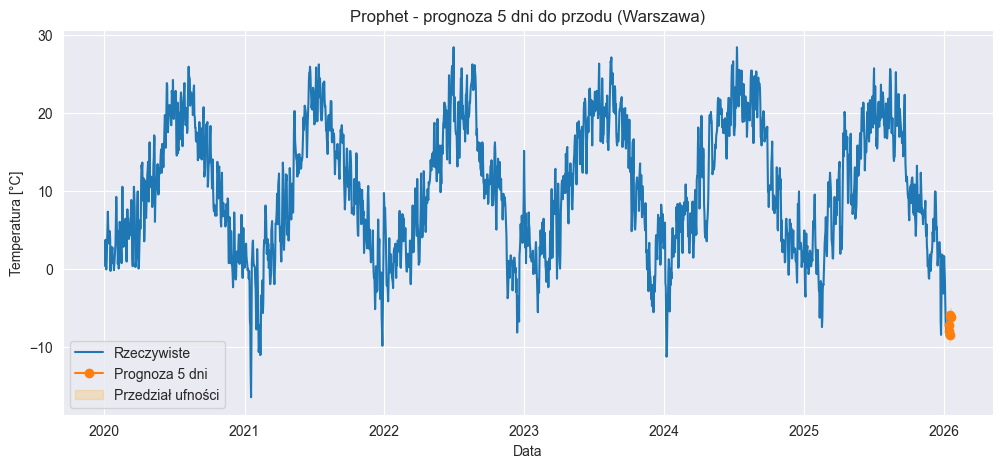

In [36]:
# =========================
# Prognoza na następne 5 dni
# =========================
future = model.make_future_dataframe(periods=5)

# 🔹 Dodanie regresorów dla przyszłości
# Tutaj użyjemy ostatnich wartości z df_city jako przybliżenia
for reg in regressors:
    last_values = df_city[reg].iloc[-5:].values
    if len(last_values) < 5:
        # jeśli mniej niż 5 dni danych, powtarzamy ostatnią wartość
        last_values = [df_city[reg].iloc[-1]] * 5
    # rozszerzamy kolumnę regresora
    future[reg] = pd.concat([df_city[reg], pd.Series(last_values)]).reset_index(drop=True).iloc[-len(future):]

# Generowanie prognozy
forecast = model.predict(future)

# =========================
# Wyświetlenie prognozy 5 dni
# =========================
forecast_5days = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(5)
print("Prognoza 5 dni do przodu (Warszawa):")
print(forecast_5days)

# =========================
# Wykres rzeczywiste vs prognoza
# =========================
plt.figure(figsize=(12,5))
plt.plot(df_city['ds'], df_city['y'], label='Rzeczywiste')
plt.plot(forecast_5days['ds'], forecast_5days['yhat'], label='Prognoza 5 dni', marker='o')
plt.fill_between(forecast_5days['ds'], forecast_5days['yhat_lower'], forecast_5days['yhat_upper'], 
                 color='orange', alpha=0.2, label='Przedział ufności')
plt.title("Prophet - prognoza 5 dni do przodu (Warszawa)")
plt.xlabel("Data")
plt.ylabel("Temperatura [°C]")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import seaborn as sns
import numpy as np

# =========================
# Predykcja na zbiorze testowym SVR
# =========================
y_pred_scaled = best_svr.predict(X_test).reshape(-1,1)

# Odwrócenie skalowania
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Dopasowanie długości (czasem może być minimalna różnica)
min_len = min(len(y_test_rescaled), len(y_pred_rescaled))
y_test_rescaled = y_test_rescaled[:min_len]
y_pred_rescaled = y_pred_rescaled[:min_len]

# =========================
# Obliczenie residuals
# =========================
residuals = y_test_rescaled - y_pred_rescaled

# =========================
# Wykres residuals w czasie
# =========================
plt.figure(figsize=(12,6))
plt.plot(
    df_city['date'].iloc[-len(residuals):],
    residuals,
    marker='o',
    linestyle='-',
    color='g'
)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals modelu SVR — błąd predykcji w czasie')
plt.xlabel('Data')
plt.ylabel('Błąd predykcji (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# Histogram residuals
# =========================
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, color='g')
plt.title('Rozkład residuals modelu SVR')
plt.xlabel('Błąd predykcji (°C)')
plt.ylabel('Częstość')
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: X has 60 features, but SVR is expecting 180 features as input.

In [17]:
from sklearn.multioutput import MultiOutputRegressor

# Tworzenie etykiet multi-step (5 dni)
forecast_horizon = 5
X_multi, y_multi = [], []
for i in range(len(df_city) - window - forecast_horizon + 1):
    X_multi.append(df_city['temp'].iloc[i:i+window].values)
    y_multi.append(df_city['temp'].iloc[i+window:i+window+forecast_horizon].values)
X_multi = np.array(X_multi)
y_multi = np.array(y_multi)

# Skalowanie
X_scaled = scaler_X.fit_transform(X_multi)
y_scaled = scaler_y.fit_transform(y_multi)
y_scaled = np.array(y_scaled)

# Trening MultiOutput SVR
multi_svr = MultiOutputRegressor(SVR(kernel='rbf', C=1232.91, gamma=0.0001192, epsilon=0.05275))
multi_svr.fit(X_scaled, y_scaled)

# Predykcja 5 dni od razu
last_window = X_scaled[-1].reshape(1, window)
future_scaled = multi_svr.predict(last_window)
future_pred = scaler_y.inverse_transform(future_scaled)
print("Prognoza 5 dni (multi-output SVR):")
print(future_pred.flatten())


Prognoza 5 dni (multi-output SVR):
[-7.33909711 -5.74957436 -4.43377069 -3.7682505  -4.32215249]
